# Analyzing SAT performance of public shcools in New York

#### Linna Ha & Chuck Zhu
#### Final Project for Data Bootcamp, Fall 2017

<div class="inline-block"> <img src="http://tribunacampeche.com/wp-content/uploads/2017/05/cenev.png" </div> 


## What determines the SAT scores of Public schools in New York?

### Background

The competition to get the best SAT scores is more and more [fierce](https://www.applerouth.com/blog/2015/01/14/raising-the-bar-with-the-new-sat/). Everyone wants to go to the best high school in order to get better scores on standardized tests such as the SAT. Students seldom know what is the real factor that determines a good school compared to a bad one. Their choice of high schools may not only decide which univerisity they are going to attend, but also maybe their entire future.

Public schools have so many different factors such as household income, teacher involvement, and school attendance. Since the problem is cruicial to our real life, yet unsolved, we want to explore what specific factors have the largest impact in the highest and lowest SAT scores in public high schools.

### Data Source

New York City provides alot of open data on the public education system. We will be using the most [recent high school quality report (2014-2015)](https://data.cityofnewyork.us/download/vrfr-9k4d/application%2Fvnd.ms-excel) which evaluates students performance and achievement based on SAT scores. The data, provided by Department of Education, contains a **district borough number (DBN)** column which classifies each district a school is located. It also includes over 30+ parameters such as economic need index, percentage in temporary housing, and safety of students. The dataset is in the from of an excel sheet with 6 tabs, which has been converted into a CSV and uploaded to github for easy access. 


### Libraries and API
There are 493 public schools in NYC. The dataset offers scores of 400 schools. Those with less than 10 students that take the SAT do no report scores. First, we chose the 2 excel tabs that provide the SAT scores and a file with variables that affect school envrionment.
Since the DBN is only used in New York, we used googlegeocoder API to match the DBN with their respective zip codes. **The geocode returns a full address of each DBN, which then we must scrape and split to only retain the borough and zipcode** After matching up the zipcode, we then further explore details about each district by merging the information with the U.S. Census API. 

Of the packages discussed in class, we will be using:
* `pandas` to create dataframes
* `numpy`
* `Census` API to merge income data with zipcodes
* `matplotlib` to graph analysis

New packages used are:
* `googlegeocoder` to align data with zipcodes 
* `geopandas` to create maps from a shapefile


In [3]:
# import packages 
import sys
import pandas as pd                   
import matplotlib.pyplot as plt      
import datetime as dt                  
import numpy as np                    
import seaborn as sns
import statistics
from scipy import stats

from googlegeocoder import GoogleGeocoder #to match up DBN with zipcode

from census import Census            
from us import states   

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pysal as ps
%matplotlib inline                     

In [4]:
api_key = "670c60e67279b6125d24adb8a5ab50638d3f1ac7"
c = Census(api_key)

#### Our Goals

1. Look at highest and lowest scoring schools
2. Look at income differences
3. Look at differences amongst boroughs
4. What factors most influence the school's performance?

### Cleaning and Merging Datasets

In [5]:
a ="https://raw.githubusercontent.com/chuckzhuisme/my_first_repository/"
b = "master/Copy%20of%202014_2015_HS_SQR_Scores.csv"
hs_scores = a + b
clean_file = "https://raw.githubusercontent.com/linnaha/NYCdata/master/sat_zip_clean.csv"
var="https://raw.githubusercontent.com/chuckzhuisme/my_first_repository/" + \
"master/Copy%20of%202014_2015_HS_SQR_Results_Summary.csv"

satdf = pd.read_csv(hs_scores, encoding='latin-1') #file with standardized test scores
variabledf = pd.read_csv(var, encoding='latin-1') #file with performance variables
satdata = pd.read_csv(clean_file, encoding='latin-1') #seperate file with just zipcodes and sat scores
satdf.head()

,DBN,School Name,Average Score Regents Algebra,Percentage Passing Regents Algebra,Percentage at college ready threshold Regents Algebra,Average Score Regents Geometry,Percentage Passing Regents Geometry,Percentage at college ready threshold Regents Geometry,Average Score Regents Algebra 2/Trig,Percentage Passing Regents Algebra 2/Trig,...,Percentage Attaining English College Readiness Standard (6 year),College and Career Preparatory Course Index,"Percentage Scoring 65+ on Alg2, MathB, Chem, or Phys Regents Exam",Percentage Scoring 3+ on any AP Exam,Percentage Scoring 4+ on any IB Exam,Percentage Earning a Diploma with a CTE Endorsement,Percentage Passing an Industry-Recognized Technical Assessment,Percentage Earning a Diploma with an Arts Endorsement,Percentage Earning a Grade of 'C' or Higher for College Credit,Percentage Passing a CPCC Course
0,01M292,Henry Street School for International Studies,64.0,52.4%,6.3%,58.0,33.3%,5.6%,NaN,NaN,...,36.0%,33.3%,1.4%,1.4%,0.0%,0.0%,0.0%,0.0%,1.4%,0.0%
1,01M448,University Neighborhood High School,64.0,55.0%,4.2%,68.0,59.8%,19.5%,62.0,53.3%,...,53.9%,67.5%,27.7%,41.0%,0.0%,0.0%,0.0%,0.0%,65.1%,0.0%
2,01M450,East Side Community School,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.8%,38.6%,0.0%,5.7%,0.0%,0.0%,0.0%,0.0%,9.1%,31.8%
3,01M509,Marta Valle High School,61.0,40.7%,2.8%,66.0,63.2%,7.9%,74.0,68.4%,...,35.6%,20.8%,11.9%,2.0%,0.0%,0.0%,0.0%,0.0%,14.9%,0.0%
4,01M539,"New Explorations into Science, Technology and ...",80.0,91.5%,53.2%,83.0,96.8%,68.6%,80.0,87.8%,...,98.5%,99.2%,99.2%,81.1%,0.0%,0.0%,0.0%,0.0%,11.5%,0.0%


There are more than 90 columns. We will make a copy of the dataframe with the just the columns of the SAT scores and DBN. 

In [6]:
df = satdata[['DBN', 'School Name', 'Average Score SAT Math','Average Score SAT Critical Reading', \
             'Average Score SAT Writing']].copy()
col_list= list(df)
col_list.remove('DBN')
col_list.remove('School Name')
col_list
df['Average SAT Score for Three sections'] = df[col_list].sum(axis=1)
df.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections
0,01M292,Henry Street School for International Studies,410,406,381,1197
1,01M448,University Neighborhood High School,437,355,352,1144
2,01M450,East Side Community School,454,428,445,1327
3,01M509,Marta Valle High School,438,413,394,1245
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859


Secondly, we will merge the dataframe with the second excel tab which includes different quality metrics.

In [7]:
#This dataset has 40 columns. Let's choose the ones we need.

variabledf1 = variabledf[['DBN', 'School Name', 'Enrollment','Collaborative Teachers Rating', \
        'Quality Review - How interesting and challenging is the curriculum?', \
        'Quality Review - How effective is the teaching and learning?', \
        'Student Attendance Rate', 'Percent Asian', 'Percent Black', \
        'Percent Hispanic', 'Percent White']].copy()
variabledf1.head()

,DBN,School Name,Enrollment,Collaborative Teachers Rating,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Student Attendance Rate,Percent Asian,Percent Black,Percent Hispanic,Percent White
0,01M292,Henry Street School for International Studies,255,Approaching Target,Developing,Developing,76.6%,13.2%,24.4%,56.6%,3.9%
1,01M448,University Neighborhood High School,304,Meeting Target,Well Developed,Proficient,88.0%,29.9%,25.0%,41.1%,3.3%
2,01M450,East Side Community School,666,Exceeding Target,Well Developed,Proficient,93.8%,9.4%,22.1%,57.9%,8.3%
3,01M509,Marta Valle High School,363,Approaching Target,Developing,Developing,76.8%,5.8%,39.9%,51.2%,2.5%
4,01M539,"New Explorations into Science, Technology and ...",1735,Approaching Target,Well Developed,Well Developed,95.2%,38.5%,13.3%,18.0%,28.6%


In [8]:
# Now lets merge the two dataframes together with DBN
del variabledf1['School Name']
combo = pd.merge(df, variabledf1,# left df, right df
                 on='DBN',       # link with cntry
                 how='left',        # add to left...does this matter here?
                 indicator=True)  # Tells us what happend
combo.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Collaborative Teachers Rating,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Student Attendance Rate,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
0,01M292,Henry Street School for International Studies,410,406,381,1197,255,Approaching Target,Developing,Developing,76.6%,13.2%,24.4%,56.6%,3.9%,both
1,01M448,University Neighborhood High School,437,355,352,1144,304,Meeting Target,Well Developed,Proficient,88.0%,29.9%,25.0%,41.1%,3.3%,both
2,01M450,East Side Community School,454,428,445,1327,666,Exceeding Target,Well Developed,Proficient,93.8%,9.4%,22.1%,57.9%,8.3%,both
3,01M509,Marta Valle High School,438,413,394,1245,363,Approaching Target,Developing,Developing,76.8%,5.8%,39.9%,51.2%,2.5%,both
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859,1735,Approaching Target,Well Developed,Well Developed,95.2%,38.5%,13.3%,18.0%,28.6%,both


Now that we have the merged data, we can start analyzing. 

## Highest and Lowest Scoring Schools

Let's take a look at the difference in scores between the top and bottom of the dataset.

In [9]:
#we may want to rename columns
#satdf = satdf.rename(columns={'School Name':'name',"Average Score SAT Math":"avg_math","Average Score SAT Critical Reading":"avg_read","Average Score SAT Writing":"avg_write","Average SAT Score for Three sections":"avg_sat"})
satdata = satdata.rename(columns={'School Name':'name',"Average Score SAT Math":"avg_math","Average Score SAT Critical Reading":"avg_read","Average Score SAT Writing":"avg_write","Average SAT Score for Three sections":"avg_sat"})

In [10]:
df.shape

(400, 6)

Of the 493 schools, 400 schools are reported with SAT scores.

In [11]:
schools = combo.groupby('School Name')
sat_avg2 = schools['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std]).sort_values(['mean'],
           ascending=False)
#nb_dist = area2['avg_dist'].agg([np.sum, np.mean, np.std])

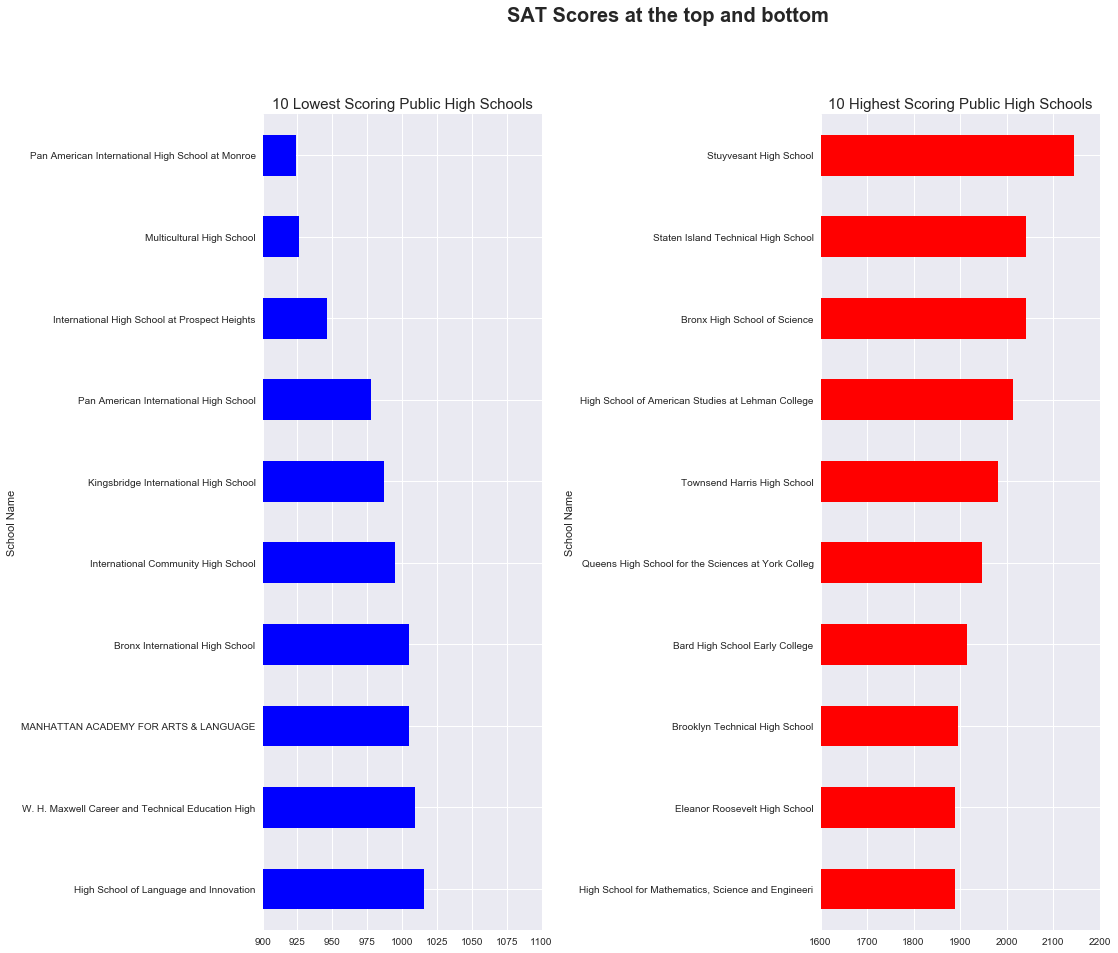

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15, 15))
fig.suptitle('SAT Scores at the top and bottom', fontsize=20, fontweight='bold')
fig.subplots_adjust(wspace=1)
sat_avg2['mean'].head(10).plot(kind='barh', ax=ax[1], color='r')
sat_avg2['mean'].tail(10).plot(kind='barh', ax=ax[0], color='b')
plt.gca().invert_yaxis() #show the highest and lowest score on top

ax[0].set_title("10 Lowest Scoring Public High Schools", fontsize=15)
ax[1].set_title("10 Highest Scoring Public High Schools", fontsize=15)
ax[0].set_xlim(900,1100)
ax[1].set_xlim(1600,2200)

plt.show()

### What are some causes for the disparity between scores?

Let's first take a look at income. We will use the U.S. Census API that we called before and merge it with our sat dataframe.

In [13]:
satdf_top = satdata[["name","avg_math","avg_read","avg_write","avg_sat","borough","zip"]].copy()
satdf_top.sort_values(by="avg_sat",ascending=False, inplace=True)

In [14]:
code = ("B19013_001E") 
#code for median houshold income
    
zip_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': "zip code tabulation area:*"}, year=2015))
#the * will get all the zipcodes. Then we will merge so that only the zipcodes that are in  our dataset will appear.

In [15]:
zip_2015 = zip_2015.rename(columns={'zip code tabulation area':'zip', 
                                    'B19013_001E':'avg_income'})

In order to merge the datasets, we must first change the dtypes to be the same.

In [16]:
zip_2015['zip'] = zip_2015['zip'].astype(str).astype(int) 

In [17]:
income_satdf = pd.merge(satdf_top,zip_2015,   
                     how='left',      # will merge with only the data in the left, which is our satdf_top
                 on='zip',       
                 indicator=True) 
income_satdf.head()

,name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
0,Stuyvesant High School,754,697,693,2144,New_York,10282,250001.0,both
1,Bronx High School of Science,714,660,667,2041,Bronx,10468,34784.0,both
2,Staten Island Technical High School,711,660,670,2041,Staten_Island,10306,79686.0,both
3,High School of American Studies at Lehman College,669,672,672,2013,Bronx,10468,34784.0,both
4,Townsend Harris High School,680,640,661,1981,Queens,11367,56557.0,both


In [18]:
income_satdf.tail()

,name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
395,Kingsbridge International High School,366,311,310,987,Bronx,10468,34784.0,both
396,Pan American International High School,340,320,318,978,Queens,11373,47588.0,both
397,International High School at Prospect Heights,344,302,300,946,Brooklyn,11225,44911.0,both
398,Multicultural High School,319,323,284,926,Brooklyn,11208,35698.0,both
399,Pan American International High School at Monroe,317,315,292,924,Bronx,10472,29308.0,both


In [19]:
income_satdf["avg_income"].head(10).mean()

81275.44444444444

In [20]:
income_satdf["avg_income"].tail(10).mean()

43274.0

The lowest scoring school, Pan American, has an average household income of $30,000.

Meanwhile, the zipcode of highest scoring school, Stuyvesant, has an average household income of ** $250,000.** 

The top 10 highest scoring schools have an average of $80,000, which is almost double the average income of the lowest scoring schools. 

One interesting thing to note is that the second highest scoring school, Bronx High School of Science, is in the same area as the one of the lowest scoring schools, Kingsbridge. 

** Does this finding resonate in all the schools? Let's look at a map. **

## Mapping SAT Scores

Using geopandas, we can create a map of the New York City area and plot our dataset onto it. First, we had to get a [shape file](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data) which contains the data of the district and zip code boundaries. Once it is downloaded, we can source it into the notebook.

Shape File Path:

In [21]:
path = "/Users/linnaha/Downloads/"

zip_file = path + "ZIP_CODE_040114" #this is for mac users

In [22]:
test = gpd.read_file(zip_file)
zipmap = pd.DataFrame(test)

In [23]:
test = test.rename(columns={'ZIPCODE':'zip'})
test['zip'] = test['zip'].astype(str).astype(int) #must change dtype from object to integer
test["zip"].dtypes #now that the zip is an integer, we can merge 

dtype('int64')

In [24]:
zipmap  = test.merge(income_satdf, on='zip', how = "outer")
zipmap.head()

,zip,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,SHAPE_LEN,geometry,name,avg_math,avg_read,avg_write,avg_sat,borough,avg_income,_merge
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Pathways in Technology Early College High Scho...,446.0,442.0,410.0,1298.0,Brooklyn,34701.0,both
2,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",KIPP AMP Charter School,452.0,411.0,418.0,1281.0,Brooklyn,34701.0,both
3,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Academy for Health Careers,406.0,405.0,396.0,1207.0,Brooklyn,34701.0,both
4,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Boys and Girls High School,399.0,392.0,394.0,1185.0,Brooklyn,34701.0,both


/Users/linnaha/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/linnaha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


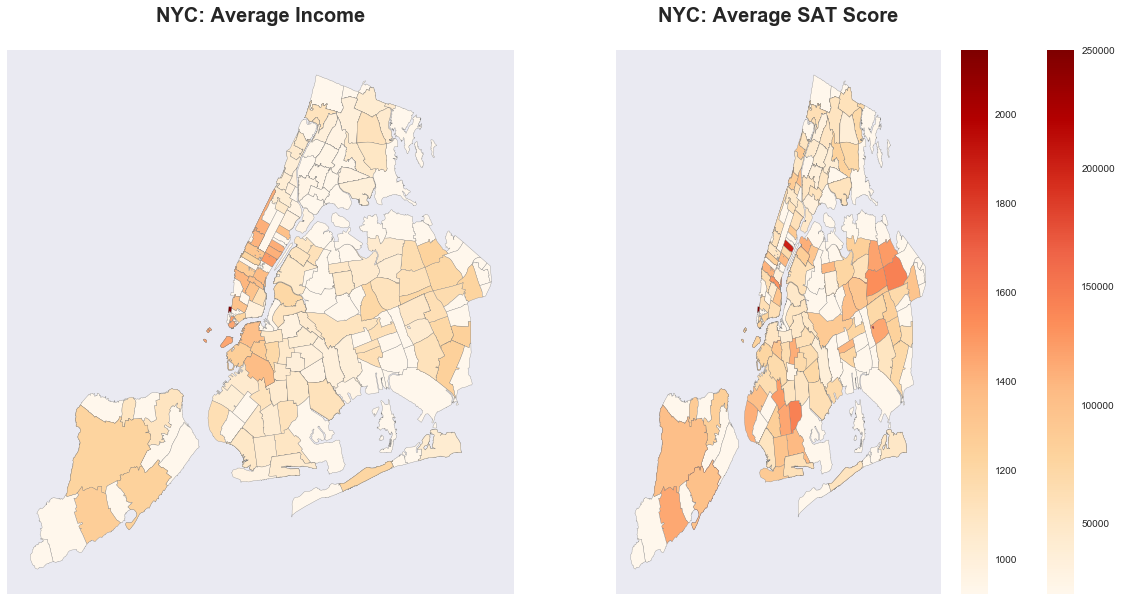

In [25]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

# First create the map for NYC
######################################################################################
# Then lets create the map for income

zipmap.plot(ax = ax[0], edgecolor='tab:grey', k =14,
             column='avg_income',
            cmap='OrRd', alpha = 1.0, 
            #scheme="Quantiles",
            legend = True )

plt.legend(loc = 2)
######################################################################################    

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[0].set_title("NYC: Average Income\n", fontsize=20, fontweight="bold")

######################################################################################
######################################################################################
# Then lets create the map for SAT scores

zipmap.plot(ax = ax[1], edgecolor='tab:grey', 
                column='avg_sat', 
            #scheme = "Quantiles"
             cmap='OrRd', 
            alpha = 1.0, legend=True, k=9,)

######################################################################################
  
    
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_title("NYC: Average SAT Score\n",fontsize=20, fontweight="bold")

ax[1].legend(loc=2)


In [140]:
zipmap["avg_sat"].describe()

count     419.000000
mean     1274.603819
std       191.325521
min       924.000000
25%      1156.000000
50%      1231.000000
75%      1328.500000
max      2144.000000
Name: avg_sat, dtype: float64

In [141]:
zipmap["avg_income"].describe()

count       418.000000
mean      56548.983254
std       29450.444582
min       20210.000000
25%       34721.750000
50%       47588.000000
75%       74442.000000
max      250001.000000
Name: avg_income, dtype: float64

* Make a legend of SAT between 900 and 2100
* Legend of avg income between 20,000 and 250,000